# NOx-HOx steady state model

This notebook contains the calculations of ozone production efficiency from a simple NOx-HOx steady state model, presented in the SI for "Societal shifts due to COVID-19 reveal large-scale complexities and feedbacks between atmospheric chemistry and climate change". It requires a Julia 1.0.5 kernel with the following packages:

* HSSModel (install v0.1.0 from [GitHub](https://github.com/joshua-laughner/HSSModel/releases/tag/v0.1.0))
* Printf
* PyPlot

and their dependencies. Versions of Julia > 1.0.5 may work but have not been tested.

To compute OPE, I use the basic from [Kleinman et al. 2002](https://doi.org/10.1029/2002JD002529), where:

$$\mathrm{OPE} = \frac{P(\mathrm{O_3})}{L(\mathrm{NO_x})} = \frac{k_\mathrm{NO+HO2}[\mathrm{NO}][\mathrm{HO_2}] + (1-\alpha)k_\mathrm{NO+RO2}[\mathrm{NO}][\mathrm{RO_2}]}{k_\mathrm{NO2+OH}[\mathrm{NO_2}][\mathrm{OH}] + \alpha k_\mathrm{NO+RO2}[\mathrm{NO}][\mathrm{RO_2}]}$$

but whereas they assume loss of NOx is just due to HNO3 formation, I'll account for alkyl nitrate formation as well.

## Running the model

In [1]:
# Model conditions - use NOx concentrations that span
# 0.01 to 10 ppb, assuming a number density of air of
# 2e19 molec. cm^-3
nox = exp10.(range(-2., stop=1., length=75)) .* 1e-9 .* 2e19;

# VOC reactivity spanning 1 to 10 s^-1
vocr = collect(transpose(range(1., stop=10., length=50)));

# NO + RO2 branching ratios spanning 0.01 to 0.1
alpha = collect(transpose(range(0.01, stop=0.1, length=50)));

# HOx production rates spanning 1e6 to 1e7 molec. cm^-3 s^-1
phox = collect(transpose(range(1e6, stop=1e7, length=50)));

# Assume a 4:1 NO2:NO ratio
no = 0.2 .* nox;
no2 = 0.8 .* nox;

In [2]:
using HSSModel;
using Printf
using PyPlot;

In [3]:
# Compute 2D results fields, using 2 varying and 2 fixed parameters each
# Fixed parameters chosen to be similar to www.atmos-chem-phys-discuss.net/6/11971/2006/
# NOx and VOCR vary, PHOx and alpha fixed
results = hox_ss_solver.(no, no2, 6.25e6, vocr, 0.04);

# NOx and PHOx vary, VOCR and alpha fixed
results_phox = hox_ss_solver.(no, no2, phox, 5.0, 0.04);

# NOx and alpha vary, PHOx and VOCR fixed
results_alpha = hox_ss_solver.(no, no2, 6.25e6, 5.0, alpha);

# PHOx and VOCR vary, NOx and alpha fixed
results_fixed_nox = hox_ss_solver.(300e-12 * 2e19 * 0.2, 300e-12 * 2e19 * 0.8, phox, transpose(vocr), 0.04);

## Plotting results

In [4]:
function ozone_prod_efficiency(result::HSSModel.SteadyStateSolvers.SteadyStateResult)
    num = ozone_prod(result);
    denom = nox_loss(result);
    
    return num / denom;
end


function ozone_prod(result::HSSModel.SteadyStateSolvers.SteadyStateResult)
    alpha = result.alpha;
    no = result.no;
    ro2 = result.ro2;
    ho2 = result.ho2;
    
    k_ro2no = result.rates["RO2+NO"];
    k_ho2no = result.rates["HO2+NO"];
    
    return (1-alpha)*k_ro2no*ro2*no + k_ho2no*ho2*no;
end


function nox_loss(result::HSSModel.SteadyStateSolvers.SteadyStateResult)
    alpha = result.alpha;
    no = result.no;
    no2 = result.no2;
    ro2 = result.ro2;
    oh = result.oh;
    
    k_ro2no = result.rates["RO2+NO"];
    k_no2oh = result.rates["NO2+OH"];
    
    return k_no2oh*no2*oh + alpha*k_ro2no*ro2*no;
end

nox_loss (generic function with 1 method)

In [6]:
# Get coordinates for the NOx-VOCR varying results
model_nox = getfield.(results, :no) + getfield.(results, :no2);
model_vocr = getfield.(results, :vocr);

In [7]:
function plot_ope(model_results, yvar, ylab, ax; xvar=:nox, cb_log10=false, vmin=nothing, vmax=nothing)
    model_nox = 1e12 / 2e19 .* (getfield.(model_results, :no) + getfield.(model_results, :no2));
    model_x = xvar == :nox ? model_nox : getfield.(model_results, xvar)
    model_y = getfield.(model_results, yvar);
    model_ope = ozone_prod_efficiency.(model_results);
    
    # convert from molec O3/molec NOx to g O3/g N
    model_ope *= 48. / 14.007;
    
    if cb_log10
        h = ax.pcolormesh(model_x, model_y, log10.(model_ope), vmin=vmin === nothing ? nothing : log10(vmin), vmax=vmax === nothing ? nothing : log10(vmax));
        cb = colorbar(h, ax=ax, label="OPE (g O\$_3\$/g N)");
        ticks = cb.get_ticks()
        cb.ax.set_yticklabels([Printf.@sprintf("%.1f", t) for t in exp10.(ticks)])
    else
        h = ax.pcolormesh(model_x, model_y, model_ope, vmin=vmin, vmax=vmax);
        cb = colorbar(h, ax=ax, label="OPE (g O\$_3\$/g N)");
    end
    
    xlabel(xvar == :nox ? "NO\$_x\$ mixing ratio (ppt)" : "$(xvar)");
    ylabel(ylab);
    if xvar == :nox
        ax.set_xscale("log")
    end
    return cb
end


function plot_o3_prod_and_nox_loss(model_results, yvar, ylab; axs=nothing, cb_log10=false)
    model_nox = 1e12 / 2e19 .* (getfield.(model_results, :no) + getfield.(model_results, :no2));
    model_y = getfield.(model_results, yvar);
    model_o3prod = ozone_prod.(model_results);
    model_noxloss = nox_loss.(model_results);
    ratio = model_o3prod ./ model_noxloss;
    
    if axs === nothing
        _, axs = subplots(1,3,figsize=(15,5), sharey=true);
    end
    
    labels = ["O\$_3\$ production (molec. cm\$^{-3}\$ s\$^{-1}\$)", "NO\$_x\$ loss (molec. cm\$^{-3}\$ s\$^{-1}\$)", "Ratio (OPE)"]
    
    for (ax, z, clab) in zip(axs, [model_o3prod, model_noxloss, ratio], labels)
        if cb_log10
            h = ax.pcolormesh(model_nox, model_y, log10.(z));
            cb = colorbar(h, ax=ax, label=clab);
            ticks = cb.get_ticks()
            cb.ax.set_yticklabels([Printf.@sprintf("%.3g", t) for t in exp10.(ticks)])
        else
            h = ax.pcolormesh(model_nox, model_y, z);
            cb = colorbar(h, ax=ax, label=clab);
        end
        #h=ax.pcolormesh(model_nox, model_y, z);
        #colorbar(h, ax=ax, label=clab);
        ax.set_xlabel("NO\$_x\$ mixing ratio (ppt)");
        ax.set_xscale("log")
    end
    
    axs[1].set_ylabel(ylab)
end


function set_cb_logticks(cb, ticks=nothing)
    if ticks === nothing
        ticks = cb.get_ticks();
    else
        ticks = log10.(ticks);
        cb.set_ticks(ticks);
    end
    
    cb.ax.set_yticklabels([Printf.@sprintf("%.3g", t) for t in exp10.(ticks)]);
end

set_cb_logticks (generic function with 2 methods)

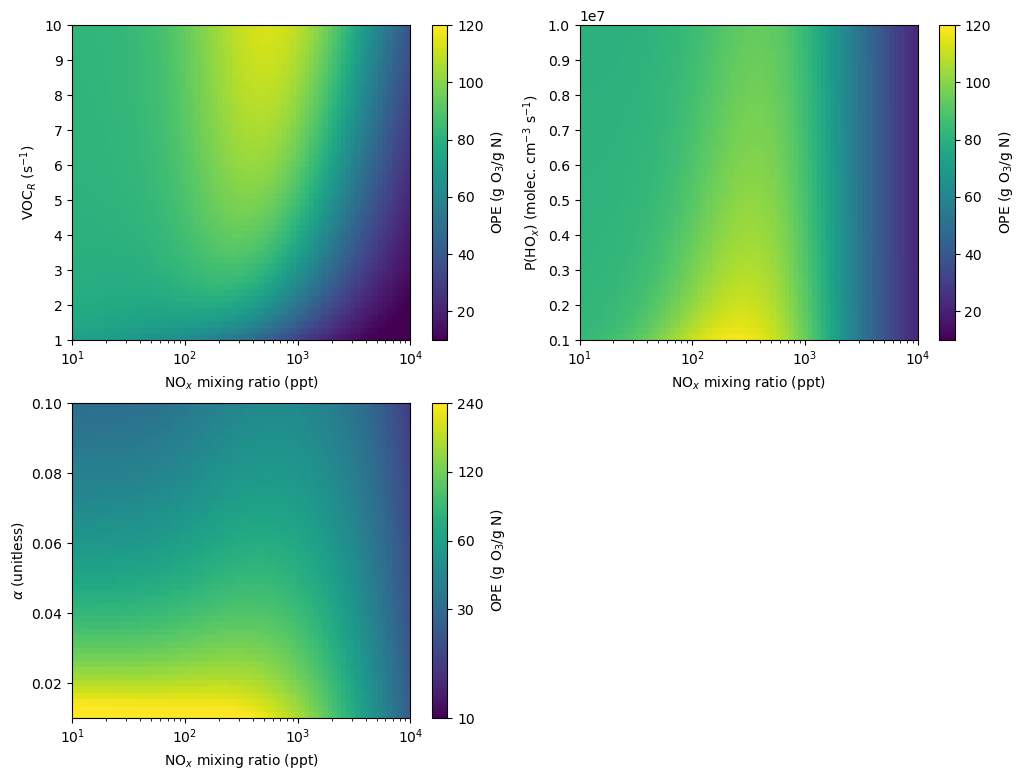

In [9]:
# Plot OPE as functions of (NOx, VOCR), (NOx, PHOx), and (NOx, alpha)
fig = figure(figsize=(12,9));
ax = fig.add_subplot(2,2,1)
plot_ope(results, :vocr, "VOC\$_R\$ (s\$^{-1}\$)", ax, vmin=10, vmax=120)

ax = fig.add_subplot(2,2,3)
cb = plot_ope(results_alpha, :alpha, "\$\\alpha\$ (unitless)", ax; cb_log10=true, vmin=10, vmax=240)
set_cb_logticks(cb, [10., 30., 60., 120., 240.])

ax = fig.add_subplot(2,2,2)
plot_ope(results_phox, :phox, "P(HO\$_x\$) (molec. cm\$^{-3}\$ s\$^{-1}\$)", ax, vmin=10, vmax=120)

ticks = cb.get_ticks()

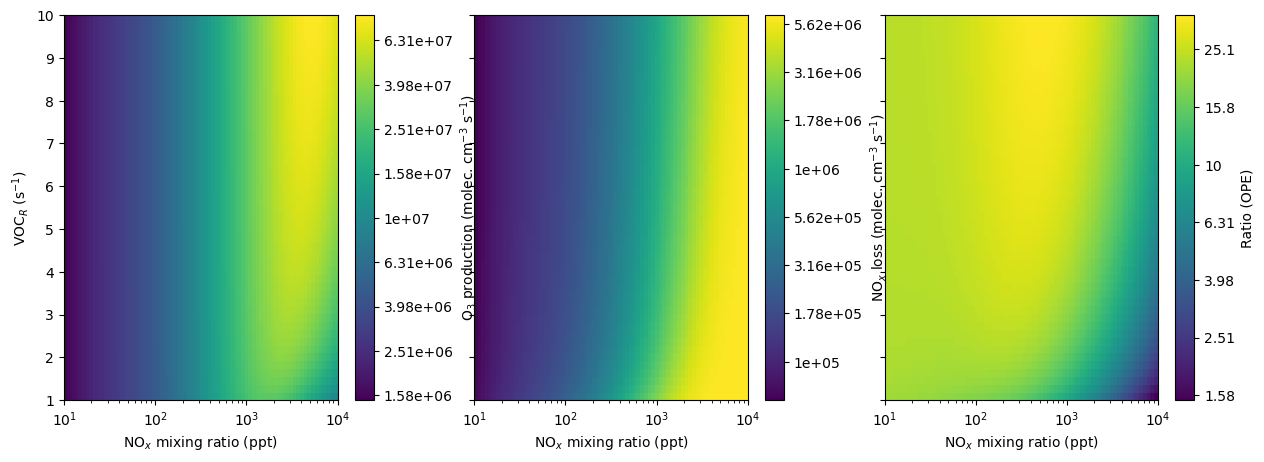

PyObject Text(30.999999999999993, 0.5, 'VOC$_R$ (s$^{-1}$)')

In [11]:
# Plot ozone production and NOx loss separately to explore which one drives the OPE
# in different regimes
plot_o3_prod_and_nox_loss(results, :vocr, "VOC\$_R\$ (s\$^{-1}\$)", cb_log10=true)

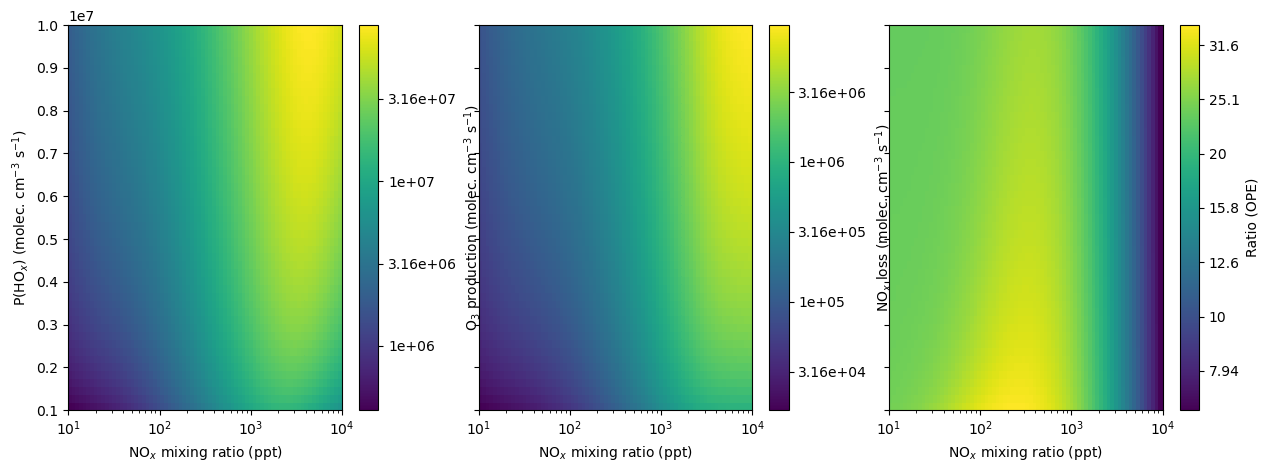

PyObject Text(30.999999999999993, 0.5, 'P(HO$_x$) (molec. cm$^{-3}$ s$^{-1}$)')

In [12]:
# Same, except the y-coordinate is PHOx rather than VOCR
plot_o3_prod_and_nox_loss(results_phox, :phox, "P(HO\$_x\$) (molec. cm\$^{-3}\$ s\$^{-1}\$)", cb_log10=true)

In [13]:
# Prepare coordinates for series plots
model_nox = 1e12/2e19 .* (getfield.(results, :no) + getfield.(results, :no2));
model_ope = ozone_prod_efficiency.(results);
model_vocr = getfield.(results, :vocr);

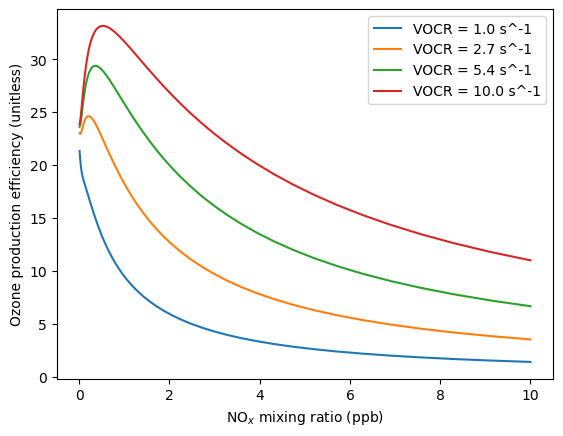

PyObject Text(24.000000000000014, 0.5, 'Ozone production efficiency (unitless)')

In [15]:
# Plot OPE vs. NOx for 4 different VOCR values to verify that
# there is a turning point (where dOPE/dNOx switches sign) for some VOCR values.
i = 1
plot(model_nox[:,i]*1e-3, model_ope[:,i], label=@sprintf("VOCR = %.1f s^-1", model_vocr[1,i]))
i = 10
plot(model_nox[:,i]*1e-3, model_ope[:,i], label=@sprintf("VOCR = %.1f s^-1", model_vocr[1,i]))
i = 25
plot(model_nox[:,i]*1e-3, model_ope[:,i], label=@sprintf("VOCR = %.1f s^-1", model_vocr[1,i]))
i = 50
plot(model_nox[:,i]*1e-3, model_ope[:,i], label=@sprintf("VOCR = %.1f s^-1", model_vocr[1,i]))
legend()
xlabel("NO\$_x\$ mixing ratio (ppb)")
ylabel("Ozone production efficiency (unitless)")